In [18]:
from utils import *

In [136]:
import pickle
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import random

In [93]:
with open( "train_test_data.pkl", "rb") as f:
    X_train, y_train, X_test, y_test = pickle.load(f)

In [98]:
X_train = pd.DataFrame(X_train.values(),index = X_train.keys()) # convert from dict to pd DataFrame
X_train['tracks'] = X_train.values.tolist() #stack all columns into one
X_train = X_train[['tracks']]

In [158]:
X_train = X_train

In [5]:
# create one hot encoding for all the tracks
X_train_onehot = pd.get_dummies(pd.DataFrame(X_train['tracks'].values.tolist()), prefix='', prefix_sep='').groupby(axis=1, level=0).max()
X_train_onehot = X_train_onehot.set_index(X_train.index)
X_train_onehot.shape #7473 101217

(7473, 101217)

In [6]:
tracks = list(X_train_onehot.columns) #all the tracks appear in the X_train

In [7]:
track_playlist_data = csr_matrix(X_train_onehot) #prepare the data matrix for the implicit package

In [90]:
X_train.head()

,tracks
323_381,"[spotify:track:6WhzFzROw3aq3rPWjgYlxr, spotify..."
323_507,"[spotify:track:7DD1ojeTUwnW65g5QuZw7X, spotify..."
323_543,"[spotify:track:61LtVmmkGr8P9I2tSPvdpf, spotify..."
323_570,"[spotify:track:0r9knJtQ6VVpX324mtkLcX, spotify..."
323_682,"[spotify:track:5vIu19A3EEdHgFM4Cba6F4, spotify..."


In [94]:
track_playlist_data.shape[0]

7473

In [ ]:
def intersect_rate(lst1, lst2): 
        return len(list(set(lst1) & set(lst2))) 

In [270]:
def score(estimator,X,y):
    def intersect_rate(lst1, lst2): 
        return len(list(set(lst1) & set(lst2))) 
    acc = 0
    acc_ind = []
    for ind in range(X.shape[0]):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = X.T
        recommendations = estimator.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in y[playlistid] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    return np.mean(acc_ind)

In [285]:
facts = range(5,105, 20)
iters = range(1,50,10)

In [284]:
print(len(facts))
print(len(iterations))

5
5


In [267]:
#create cv index
cv = 2
l = X_train.shape[0]
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, l, l//n):
        # Create an index range for l of n items:
        linspace = np.linspace(i,i+(l//n),(l//n))
        index = [int(j) for j in list(linspace)]
        yield index     
train_cv_ind = list(chunks(l,cv))

In [268]:
ind = [i for i in range(cv) if i != 0]
print(ind)
np.concatenate([train_cv_ind[i] for i in ind] )

[1]


array([3736, 3737, 3738, ..., 7469, 7470, 7472])

In [293]:
acc_val_iter = np.zeros(5)
acc_train_iter = np.zeros(5)
i = 0
for it in iters:
    acc_val_fac = []
    acc_train_fac = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model = implicit.als.AlternatingLeastSquares(factors = 25,iterations = it)
        model.fit(X.T)
        acc_val_fac.append(score(model,X_test,y_test))
        acc_train_fac.append(score(model,X,y))
    acc_val_iter[i] = np.mean(acc_val_fac)
    acc_train_iter[i] = np.mean(acc_train_fac)
    print(acc_val_iter)
    print(acc_train_iter)
    i = i + 1     


[0.16033191 0.         0.         0.         0.        ]
[0.86308887 0.         0.         0.         0.        ]



[0.16033191 0.12205567 0.         0.         0.        ]
[0.86308887 2.02944325 0.         0.         0.        ]



[0.16033191 0.12205567 0.12968415 0.         0.        ]
[0.86308887 2.02944325 1.99705567 0.         0.        ]



[0.16033191 0.12205567 0.12968415 0.12446467 0.        ]
[0.86308887 2.02944325 1.99705567 2.00026767 0.        ]



[0.16033191 0.12205567 0.12968415 0.12446467 0.12874732]
[0.86308887 2.02944325 1.99705567 2.00026767 1.98153105]


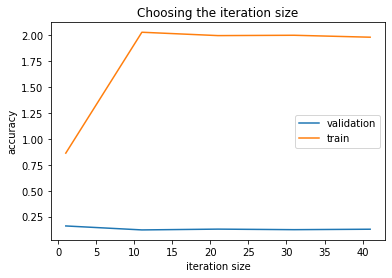

In [294]:
plt.plot(np.arange(1,50,10),acc_val_iter, label = 'validation')
plt.plot(np.arange(1,50,10),acc_train_iter, label = 'train')
plt.xlabel('iteration size')
plt.ylabel('accuracy')
plt.title('Choosing the iteration size')
plt.legend()
plt.show()


In [289]:
acc_val = np.zeros(5)
acc_train = np.zeros(5)
i = 0
for fac in facts:
    acc_val_fac = []
    acc_train_fac = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model = implicit.als.AlternatingLeastSquares(factors = fac,iterations = 11)
        model.fit(X.T)
        acc_val_fac.append(score(model,X_test,y_test))
        acc_train_fac.append(score(model,X,y))
    acc_val[i] = np.mean(acc_val_fac)
    acc_train[i] = np.mean(acc_train_fac)
    print(acc_train)
    print(acc_val)
    i = i + 1     


[0.79068522 0.         0.         0.         0.        ]
[0.16956638 0.         0.         0.         0.        ]



[0.79068522 2.00963597 0.         0.         0.        ]
[0.16956638 0.12607066 0.         0.         0.        ]



[0.79068522 2.00963597 2.73942719 0.         0.        ]
[0.16956638 0.12607066 0.11041221 0.         0.        ]



[0.79068522 2.00963597 2.73942719 3.30902034 0.        ]
[0.16956638 0.12607066 0.11041221 0.10505889 0.        ]



[0.79068522 2.00963597 2.73942719 3.30902034 3.75950214]
[0.16956638 0.12607066 0.11041221 0.10505889 0.10037473]


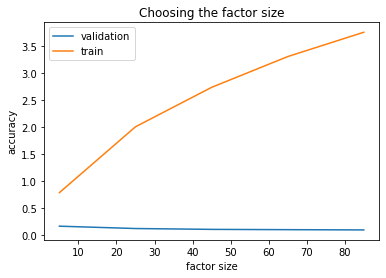

In [291]:
plt.plot(np.arange(5,105, 20),acc_val, label = 'validation')
plt.plot(np.arange(5,105, 20),acc_train, label = 'train')
plt.xlabel('factor size')
plt.ylabel('accuracy')
plt.title('Choosing the factor size')
plt.legend()
plt.show()

In [288]:
# 'best' model so far
model = implicit.als.AlternatingLeastSquares(factors=25, iterations = 11)
# train the model on a sparse matrix of item/user/confidence weights
model.fit(track_playlist_data.T)
score(model,track_playlist_data,X_train.tracks)

1.1241803827110932

# -------END---------- 辛苦了！

In [278]:
model = implicit.als.AlternatingLeastSquares(factors=10)

    # train the model on a sparse matrix of item/user/confidence weights
model.fit(track_playlist_data.T)

acc = 0
acc_ind = []
for ind in range(7473):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data.T
    recommendations = model.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0]]
    playlist_true = [j for j in X_train.tracks[playlistid] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))
print(np.mean(acc_ind))


1.117489629332263


In [117]:
print('Overall accuracy of ALS: ', np.mean(acc_ind))

Overall accuracy of ALS:  1.1597751906864713


In [ ]:
import implicit
acc_mean = np.zeros(10)
i = 0
for fac in np.arange(0,100,10):
    # initialize a model
    model = implicit.als.AlternatingLeastSquares(factors=fac)

    # train the model on a sparse matrix of item/user/confidence weights
    model.fit(track_playlist_data.T)

    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[0] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    i = i + 1


In [83]:
import implicit
acc_mean = np.zeros(10)
i = 0
for fac in np.arange(0,100,10):
    # initialize a model
    model = implicit.als.AlternatingLeastSquares(factors=fac)

    # train the model on a sparse matrix of item/user/confidence weights
    model.fit(track_playlist_data.T)

    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[ind] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    i = i + 1


KeyboardInterrupt: 

In [84]:
import implicit
acc_mean = np.zeros(10)
i = 0
for it in np.arange(0,100,10):
    # initialize a model
    model = implicit.als.AlternatingLeastSquares(factors=10, iterations = it)
    
    # train the model on a sparse matrix of item/user/confidence weights
    model.fit(track_playlist_data.T)

    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[ind] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    print(acc_mean[i])
    i = i + 1


KeyboardInterrupt: 

In [190]:
print(acc_ind)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [54]:
from implicit.lmf import LogisticMatrixFactorization

In [71]:
import implicit
acc_mean = np.zeros(10)
i = 0
for it in np.arange(1,150,15):
    # initialize a model
    model_mf = LogisticMatrixFactorization(factors = 30, iterations = it)

    # train the model on a sparse matrix of item/user/confidence weights
    model_mf.fit(track_playlist_data.T)
    
    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model_mf.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[0] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    print(acc_mean[i])
    i = i + 1



0.0005352602703064365



0.10089656095276328



0.07413354743744145



0.09433962264150944


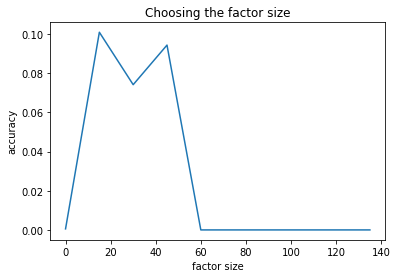

In [75]:
plt.plot(np.arange(1,150,15),acc_mean)
plt.xlabel('factor size')
plt.ylabel('accuracy')
plt.title('Choosing the factor size')
plt.show()

In [77]:
# initialize a model
model_mf = LogisticMatrixFactorization(factors = 30, iterations = 100)

# train the model on a sparse matrix of item/user/confidence weights
model_mf.fit(track_playlist_data.T)
    
acc = 0
acc_ind = []
for ind in range(7473):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data.tocsr()
    recommendations = model_mf.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
    playlist_true = [j for j in X_train.tracks[0] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))

In [78]:
print('Overall accuracy of Logistic Matrix Factorization: ', np.mean(acc_ind))

Overall accuracy of Logistic Matrix Factorization:  0.1026361568312592


In [26]:
# show how the csr_matrix works
raw = [[0.0, 2.0, 1.5, 1.33333333, 1.25, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 2.0, 1.5, 1.33333333, 1.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333, 1.25, 1.2],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333, 1.25],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
counts = csr_matrix(raw, dtype=np.float64)
print(counts)

  (0, 1)	2.0
  (0, 2)	1.5
  (0, 3)	1.33333333
  (0, 4)	1.25
  (0, 5)	1.2
  (1, 2)	2.0
  (1, 3)	1.5
  (1, 4)	1.33333333
  (1, 5)	1.25
  (2, 3)	2.0
  (2, 4)	1.5
  (2, 5)	1.33333333
  (3, 4)	2.0
  (3, 5)	1.5
  (4, 5)	2.0
  (6, 7)	2.0
  (6, 8)	1.5
  (6, 9)	1.33333333
  (6, 10)	1.25
  (6, 11)	1.2
  (7, 8)	2.0
  (7, 9)	1.5
  (7, 10)	1.33333333
  (7, 11)	1.25
  (8, 9)	2.0
  (8, 10)	1.5
  (8, 11)	1.33333333
  (9, 10)	2.0
  (9, 11)	1.5
  (10, 11)	2.0


In [57]:
from implicit.bpr import BayesianPersonalizedRanking
acc_mean = np.zeros(5)
i = 0
for lr in [0.001,0.01,0.05,0.1,1]:
    # initialize a model
    model_bay = BayesianPersonalizedRanking(factors = 30, iterations = 50, learning_rate = lr)

    # train the model on a sparse matrix of item/user/confidence weights
    model_bay.fit(track_playlist_data.T)

    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model_bay.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[0] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    print(acc_mean[i])
    i = i + 1

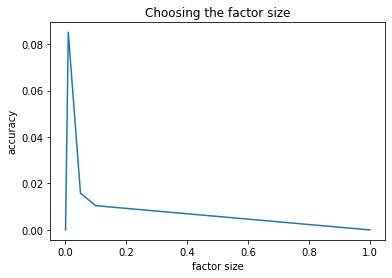

In [58]:
plt.plot([0.001,0.01,0.05,0.1,1],acc_mean)
plt.xlabel('factor size')
plt.ylabel('accuracy')
plt.title('Choosing the factor size')
plt.show()

In [64]:
 # initialize a model
model_bay = BayesianPersonalizedRanking(factors = 30,iterations = 100, learning_rate = 0.01,verify_negative_samples = True)

    # train the model on a sparse matrix of item/user/confidence weights
model_bay.fit(track_playlist_data.T)
acc = 0
acc_ind = []
for ind in range(7473):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data.tocsr()
    recommendations = model_bay.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
    playlist_true = [j for j in X_train.tracks[0] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))

In [65]:
print('Overall accuracy of Bayesian Personalized Ranking: ', np.mean(acc_ind))

Overall accuracy of Bayesian Personalized Ranking:  0.026763013515321826
